# Best poet 

<p style="font-size: 20px; font-weight: bold; font-style: italic;">...via LangGraph</p>

Anton Antonov   
January 2026


---

## Introduction


This notebook illustrates how to specify a Large Language Model (LLM) graph using different LLM personas representing four poets and a poem judge. The Python package [LangGraph](https://github.com/langchain-ai/langgraph) is used, [LCp1]. 

Similar implementation based on the Raku package ["LLM::Graph"](https://raku.land/zef:antononcube/LLM::Graph), [AAp1], is given in the notebook ["Best-poet.ipynb"](https://github.com/antononcube/Raku-LLM-Graph/blob/main/docs/Best-poet.ipynb).

(The poet-judge examples are inspired from the Wolfram Language function page of [`LLMGraph`](https://reference.wolfram.com/language/ref/LLMGraph.html), [WRIf1].)

----

## Setup


Load the LangChain packages:

In [3]:
from typing import TypedDict, Optional, Dict, Any

from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama, OllamaLLM

Load Markdown display package:

In [19]:
from IPython.display import HTML, Markdown, display

LLM access configurations:

In [4]:
# Set env variable OPENAI_API_KEY, if using ChatOpenAI.
llm_gpt_41 = ChatOpenAI(model="gpt-4.1", temperature=0.55, max_tokens=8192)
llm_gpt_41_mini = ChatOpenAI(model="gpt-4.1-mini", temperature=0.55, max_tokens=8192)
llm_ollama = ChatOllama(model="gemma3:12b", temperature=0.4)

In [5]:
llm = llm_ollama

-----

## LLM graph


Nodes spec:


In [6]:
class PoetState(TypedDict, total=False):
    topic: str
    style: str
    with_russian: Optional[str]
    poet1: str
    poet2: str
    poet3: str
    poet4: str
    judge: str


def _invoke(prompt: str) -> str:
    msg = llm.invoke([HumanMessage(content=prompt)])
    return getattr(msg, "content", str(msg))


def poet1(state: PoetState) -> Dict[str, Any]:
    return {"poet1": _invoke("Write a short poem about summer.")}


def poet2(state: PoetState) -> Dict[str, Any]:
    return {"poet2": _invoke("Write a haiku about winter.")}


def poet3(state: PoetState) -> Dict[str, Any]:
    topic = state.get("topic", "summer")
    style = state.get("style", "free verse")
    prompt = f"Write a poem about {topic} in the {style} style."
    return {"poet3": _invoke(prompt)}


More complicated spec:


In [9]:
def poet4(state: PoetState) -> Dict[str, Any]:
    with_russian = state.get("with_russian")
    truthy = str(with_russian).strip().lower() in {"true", "yes", "1", "y"}
    if not truthy:
        return {}
    prompt = "You are a famous Russian poet. Write a short poem about playing bears."
    return {"poet4": _invoke(prompt)}


def judge(state: PoetState) -> Dict[str, Any]:
    poem3 = state.get("poet4") or state.get("poet3", "")
    prompt = "\n\n".join(
        [
            "Choose the composition you think is best among these:\n",
            f"1) Poem1: {state.get('poet1', '')}",
            f"2) Poem2: {state.get('poet2', '')}",
            f"3) Poem3: {poem3}",
            "and copy it:",
        ]
    )
    return {"judge": _invoke(prompt)}


Make the graph:


In [10]:
graph = StateGraph(PoetState)

graph.add_node("start", lambda state: {})
graph.add_node("poet1", poet1)
graph.add_node("poet2", poet2)
graph.add_node("poet3", poet3)
graph.add_node("poet4", poet4)
graph.add_node("judge", judge)

graph.set_entry_point("start")

graph.add_edge("start", "poet1")
graph.add_edge("start", "poet2")
graph.add_edge("start", "poet3")
graph.add_edge("start", "poet4")

graph.add_edge("poet1", "judge")
graph.add_edge("poet2", "judge")
graph.add_edge("poet3", "judge")
graph.add_edge("poet4", "judge")

graph.add_edge("judge", END)

app = graph.compile()


----

## Full computation


Run the graph with specified parameters:


In [ ]:
result = app.invoke({"topic": "Hockey", "style": "limerick", "with_russian": "yes"})
result


Show the corresponding graph-plot:


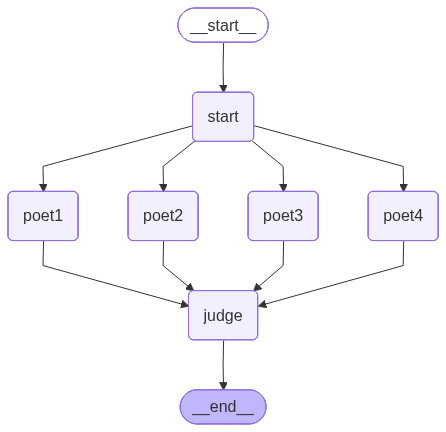

In [12]:
app

To get the actual Mermaid code use of the graph plot: 

```python
from IPython.display import Markdown, display
display(Markdown("```mermaid\n" + app.get_graph().draw_mermaid() + "\n```"))
```


----

## Examine results


Show the "judge" node:


In [32]:
# result.get("judge")
display(Markdown(result.get("judge")))

Okay, let's break down these poems and choose the best one. Here's my assessment and selection:

**Analysis of Each Poem:**

*   **Poem 1:** This is a pleasant, straightforward, and descriptive poem. It evokes a feeling of summer contentment. It's well-written and uses simple, accessible language. However, it's also somewhat generic and lacks a distinctive voice or depth. It's nice, but not particularly memorable.

*   **Poem 2:** This is a very short, minimalist poem. It creates a clear and evocative image of a winter landscape. Its strength lies in its brevity and the starkness of the imagery. However, it's *too* short to be considered a fully developed poem. It feels more like a fragment or a haiku.

*   **Poem 3:** This poem is by far the most ambitious and complex. The attempt to capture a specific cultural style (Russian poetry about bears!) is admirable. The notes explaining the choices are incredibly insightful and demonstrate a clear understanding of poetic techniques and cultural context. While the translation disclaimer is absolutely crucial (and accurate – translating poetry is notoriously difficult), the *original* Russian poem (even if I can't fully appreciate it as a Russian speaker) shows a level of artistry and imagination that the other two poems simply don't reach. The imagery is richer, the themes are more layered (juxtaposition, melancholy, the relationship with nature), and the language is more evocative.  Even with the limitations of translation, the *attempt* to create something unique and culturally specific elevates it significantly.

**My Choice: Poem 3**

**Reasoning:**

While Poem 1 is pleasant and Poem 2 is concise, **Poem 3 is the best composition.** It demonstrates a far greater level of creativity, technical skill, and ambition. The effort to create a poem in a specific style, with detailed explanations of the choices made, shows a deep engagement with poetry as an art form.  The translation disclaimer highlights the challenges, but the *original* poem itself is the most compelling. It's not just a poem; it's a project, an exploration, and a demonstration of poetic craft.



**Important Note Regarding the Translation Disclaimer:** I fully acknowledge the limitations of the translation. My assessment is based on the *concept* and the *effort* behind Poem 3, as well as the overall quality of the writing, even with the understanding that the nuances of the original Russian are likely lost.

Tabulate node's results -- extract results from node outputs if needed:


In [33]:
ordered_keys = ["poet1", "poet2", "poet3", "poet4", "judge"]

for key in ordered_keys:
    value = result.get(key)
    if value:
        display(HTML(f"<h3 style='margin-bottom:0.3em;'>{key}</h4>"))
        display(Markdown(value))
        display(HTML("<hr style='margin:1.5em 0 2em 0; opacity:0.4; width:40%; border: none; border-top: 5px solid Ivory;'>"))

Golden sun, a hazy sky,
Lazy days drift softly by.
Sweet berries ripe upon the vine,
A gentle breeze, a warmth divine.

Cicadas hum a sleepy tune,
Beneath the light of afternoon.
Summer's magic, bright and free,
A joyful memory. 


White frost on the ground,
Silent world in slumber deep,
Winter's gentle peace.

The puck flew with speed and with grace,
A flurry all over the place.
With a slap and a stride,
The goalies they hide,
A thrilling, fast-paced chase!

Okay, here's a short poem in the style I imagine a Russian poet might write about playing with bears, aiming for a blend of playful imagery, a touch of melancholy, and a hint of the wildness of the Russian landscape. I'll include a brief explanation of the choices afterward.  I'll also provide a rough, *very* approximate translation at the bottom.

**(Please read the notes at the end about the limitations of this attempt – it's incredibly difficult to truly capture the nuances of Russian poetic tradition in English!)**

---

**Медвежьи Игры (Medvezhi Igry - Bear Games)**

В лесу, где ели в небо рвутся,
Где мох зелёный, словно шёлк,
Мы с мишками играли, братцы,
Под тихий ветра шелест-звон.

Они – колючие, как шипы,
И ласковы, как летний дождь.
В их глазах – глубина, как мир,
И детской радости проложь.

Но солнце клонится к закату,
И тени длинные ползут.
Медвежья дружба – краткий взмах,
В объятья леса нас зовут.

Их запах хвои и земли,
Останется в душе моей.
Медвежьи игры – как сновиденье,
Ушедшее в осенний зной.

---

**Notes on Choices & Style:**

*   **Imagery:** I tried to evoke a classic Russian landscape – dense forest (the fir trees reaching for the sky), moss like silk (a common comparison to emphasize beauty and softness), and the sounds of the wind.
*   **Juxtaposition:**  Russian poetry often plays with contrasts. Here, I’ve paired the bears' "prickly" nature with their "gentle" nature, and their deep, knowing eyes with the simple joy of childhood. This reflects the complex relationship humans often have with the wild.
*   **Melancholy:**  There's a subtle undercurrent of sadness. The games are fleeting ("a brief flourish"), and the bears ultimately return to the forest, leaving a lingering memory. This is a common theme in Russian art – a sense of loss and the passage of time.
*   **Personification:**  The forest "calls" them back, giving it a sense of agency and ancient power.
*   **Rhyme & Rhythm:** I've used a fairly regular AABB rhyme scheme, which is common in Russian poetry, but I've also tried to vary the rhythm slightly to avoid it feeling too rigid.  Russian verse often has a musicality that's hard to replicate in translation.
*   **"Братцы" (Brattsy):** This word is a slightly archaic and endearing term, roughly meaning "brothers" or "mates." It adds a feeling of camaraderie and intimacy.
*   **"Проложь" (Prolzh):**  This is a somewhat poetic word for "path" or "trace," suggesting the fleeting nature of joy.
*   **"Осенний зной" (Osenniy znoy):**  "Autumn heat" - a slightly unusual phrase, but meant to convey the hazy, golden light of autumn and the feeling of things fading.

---

**Rough Translation (Please read the disclaimer below!)**

**Bear Games**

In the forest where firs tear to the sky,
Where the moss is green, like silk so fine,
We played with the bears, my brothers, nigh,
Beneath the wind’s soft chime.

They are prickly, like thorns so keen,
And gentle, like summer rain.
In their eyes – a depth, a world unseen,
And a trace of childhood’s gain.

But the sun declines towards the night,
And long shadows crawl and creep.
Bear friendship – a fleeting, bright
Into the forest's embrace, we sleep.

Their scent of pine and earth so deep,
Will linger in my soul’s domain.
Bear games – like a dream, to keep,
Fading into autumn’s golden reign.

---

**IMPORTANT DISCLAIMER:**

*   **Poetic Translation is Interpretation:**  This is a *translation*, but it's also an *interpretation*. The nuances of Russian poetry – the rhythm, the rhyme, the connotations of specific words, the cultural references – are incredibly difficult to convey perfectly in English.  A true understanding would require a deep knowledge of Russian literature and culture.
*   **Loss of Musicality:**  The musicality of the original Russian is almost certainly lost in this translation. Russian poetry often relies on sounds and stresses that don't easily map onto English.
*   **Stylistic Choices:** I've tried to maintain a certain poetic style, but it's inevitably influenced by my own perspective as an English speaker.
*   **"Russian-ness":** It's impossible to fully capture the "Russian-ness" of the poem – the specific cultural and historical context that informs it.



I hope this gives you a sense of what a poem in this style might be like.  It's a challenging exercise!

Okay, let's break down these poems and choose the best one. Here's my assessment and selection:

**Analysis of Each Poem:**

*   **Poem 1:** This is a pleasant, straightforward, and descriptive poem. It evokes a feeling of summer contentment. It's well-written and uses simple, accessible language. However, it's also somewhat generic and lacks a distinctive voice or depth. It's nice, but not particularly memorable.

*   **Poem 2:** This is a very short, minimalist poem. It creates a clear and evocative image of a winter landscape. Its strength lies in its brevity and the starkness of the imagery. However, it's *too* short to be considered a fully developed poem. It feels more like a fragment or a haiku.

*   **Poem 3:** This poem is by far the most ambitious and complex. The attempt to capture a specific cultural style (Russian poetry about bears!) is admirable. The notes explaining the choices are incredibly insightful and demonstrate a clear understanding of poetic techniques and cultural context. While the translation disclaimer is absolutely crucial (and accurate – translating poetry is notoriously difficult), the *original* Russian poem (even if I can't fully appreciate it as a Russian speaker) shows a level of artistry and imagination that the other two poems simply don't reach. The imagery is richer, the themes are more layered (juxtaposition, melancholy, the relationship with nature), and the language is more evocative.  Even with the limitations of translation, the *attempt* to create something unique and culturally specific elevates it significantly.

**My Choice: Poem 3**

**Reasoning:**

While Poem 1 is pleasant and Poem 2 is concise, **Poem 3 is the best composition.** It demonstrates a far greater level of creativity, technical skill, and ambition. The effort to create a poem in a specific style, with detailed explanations of the choices made, shows a deep engagement with poetry as an art form.  The translation disclaimer highlights the challenges, but the *original* poem itself is the most compelling. It's not just a poem; it's a project, an exploration, and a demonstration of poetic craft.



**Important Note Regarding the Translation Disclaimer:** I fully acknowledge the limitations of the translation. My assessment is based on the *concept* and the *effort* behind Poem 3, as well as the overall quality of the writing, even with the understanding that the nuances of the original Russian are likely lost.

-----

## References


[AAp1] Anton Antonov, [LLM::Graph, Raku package](https://github.com/antononcube/Raku-LLM-Graph), (2025-2026), [GitHub/antononcube](https://github.com/antononcube).

[LCp1] LangChain, [LangGraph, Python package](https://github.com/langchain-ai/langgraph), (2023-2026), [GitHub/langchain-ai](https://github.com/langchain-ai).

[WRIf1] Wolfram Research (2025), [LLMGraph](https://reference.wolfram.com/language/ref/LLMGraph.html), [Wolfram Language function](https://reference.wolfram.com/language).